In [1]:
# Esto produce un error debido a que no queremos perder estas imagenes, ya no disponibles a nivel de código debido a una reestructuración del proyecto.
print(1/0)

ZeroDivisionError: division by zero

# Explorando Métricas de Rendimiento para el MoDem LoRa: Método de Montecarlo



En el siguiente Notebook se explorarán las métricas de renidmiento obtenidas al someter a nuestra implementación LoRa a un compendio de escenarios y configuraciones, **todas en un marco de simulación, apoyado por el método Montecarlo**.

#### Método de Montercarlo

El **método de Montecarlo** consiste en realizar un gran número de simulaciones aleatorias para estimar el comportamiento promedio de un sistema. En este caso, se generan millones de transmisiones con distintos niveles de ruido (SNR), y se mide cuántas fallan para obtener métricas como BER, SER o FER de forma estadísticamente robusta.


## 1. Integrando soluciones de visualización: `plot_helpers.py`




Es una colección de funciones que automatizan la visualización del rendimiento de sistemas LoRa en distintos escenarios y configuraciones. Se centra particularmente en representar métricas como BER (Bit Error Rate), SER (Symbol Error Rate) y FER (Frame Error Rate) frente a variaciones del SNR (Signal-to-Noise Ratio).

El propósito principal del archivo es cargar archivos binarios .npy con resultados de simulaciones del método Montecarlo y graficar curvas BER/SER/PER vs SNR. Además, se implementa una heurística de filtrado para evitar mostrar puntos de simulación que son estadísticamente poco confiables.

> NOTA: Los datos están disponibles en legacy_performance/data, pero su archivo de generación fue perdido en una refactorización.

### 1.1. La heurística de filtrado
Los archivos binarios .npy generados originalmente no aplicaban ningún criterio para descartar puntos estadísticamente poco confiables (por ejemplo, cuando se detectan muy pocos errores para cierto valor de SNR).

Por esta razón, se implementa una heurística de filtrado directamente en la etapa de visualización, que descarta aquellos puntos cuya métrica de error sea tan baja que podría haber sido producto del azar y no representar la realidad.

El criterio se basa en lo siguiente:
> **Un valor de error es considerado poco confiable si fue calculado a partir de menos de N errores observados.**

Dado que conocemos el número total de simulaciones realizadas por punto de SNR (num_simulations), podemos calcular un umbral mínimo (threshold) por debajo del cual los datos deben descartarse:

```python
threshold = ERRORS_PER_SNR_POINT / num_simulations
```
Donde:
- ```ERRORS_PER_SNR_POINT```: es un valor constante (por ejemplo, 100) que representa la cantidad mínima de errores que se deben observar para considerar válida una estimación.

- ```num_simulations```: es el número de repeticiones realizadas para ese punto de SNR.

### 1.2. Funciones principales

Existen las funciones de graficado unitario, que de manera atómica convierten los datos binarios en representaicones visuales:

- `plot_BER_SNR_from_binary(...)`: Grafica BER vs SNR

- `plot_SER_SNR_from_binary(...)`: Grafica SER vs SNR

- `plot_PER_SNR_from_binary(...)`: Grafica PER vs SNR (en contexto de Trama)

- `plot_relative_SER_SNR_from_binary(...)`: Grafica SER vs SNR (en contexto de Trama)

Y luego las funciones para visualizar de forma compuesta características de rendimiento del MoDem LoRa:

- `plot_all_snr_ber()`: Subplots comparando distintos SF y SPC para BER

- `plot_all_snr_ser()`: Subplots comparando distintos SF y SPC para SER

- `plot_vangelista_comparison()`: Comparación entre nuestra implementación y la de Vangelista

- `plot_frame_corr_performance()`, `plot_frame_dechirp_performance()`: Comparación de modos de sincronización

- `plot_frame_corr_mode_comparison()`, `plot_frame_dechirp_vs_corr_performance()`: Comparaciones específicas entre sincronizadores

## 2. Explorando métricas de rendimiento: SNR × BER





La figura muestra cuatro gráficos que ilustran la evolución de la **tasa de error de bit (BER)** en función del **SNR (Signal-to-Noise Ratio)** bajo diferentes configuraciones de modulación LoRa. Las simulaciones se realizaron tanto en canal **AWGN** (Additive White Gaussian Noise) como en un canal **selectivo en frecuencia**, modelado mediante una respuesta al impulso discreta:

$$
h(nT) = \sqrt{0.8} \, \delta(nT) + \sqrt{0.2} \, \delta(nT - T)
$$



### 2.1. Parte superior: Canal AWGN

* **Izquierda (variación del Spreading Factor)**
  Se observa que al aumentar el **SF (Spreading Factor)**, el sistema mejora significativamente su BER para un mismo valor de SNR. Esto se debe a que un mayor SF implica mayor redundancia y mejor resistencia al ruido, aunque a costa de menor velocidad de transmisión.

* **Derecha (variación de Samples per Chip)**
  Aumentar el **SPC (Samples per Chip)** también mejora la BER, pero con una ganancia que se **satura**: pasar de SPC=1 a SPC=2 mejora mucho, pero de SPC=8 a SPC=10 la mejora es marginal. Esto sugiere un rendimiento **asimptótico** (converge en una asíntota logarítmica) con respecto al oversampling.



### 2.2. Parte inferior: Canal Selectivo en Frecuencia

* Los patrones generales se mantienen, pero el **canal degradado introduce una penalización** clara en la BER, desplazando las curvas hacia la derecha (requiere mayor SNR para lograr la misma BER que en el canal AWGN).
* Aun así, **SF sigue mostrando mejoras sostenidas**, mientras que **SPC mantiene su comportamiento convergente**.



### Conclusión

* Aumentar SF es altamente efectivo para mejorar la robustez del sistema, aunque penaliza el rendimiento a nivel de transferencia de bits.
* Aumentar SPC también ayuda, pero con retornos decrecientes más allá de cierto punto.
* En presencia de canales más hostiles (selectivos en frecuencia) el piso de BER se mueve a la derecha y se deforma de la clásica curva logarítimica, aunque sigue siendo performante en ambientes con SNR negativos.

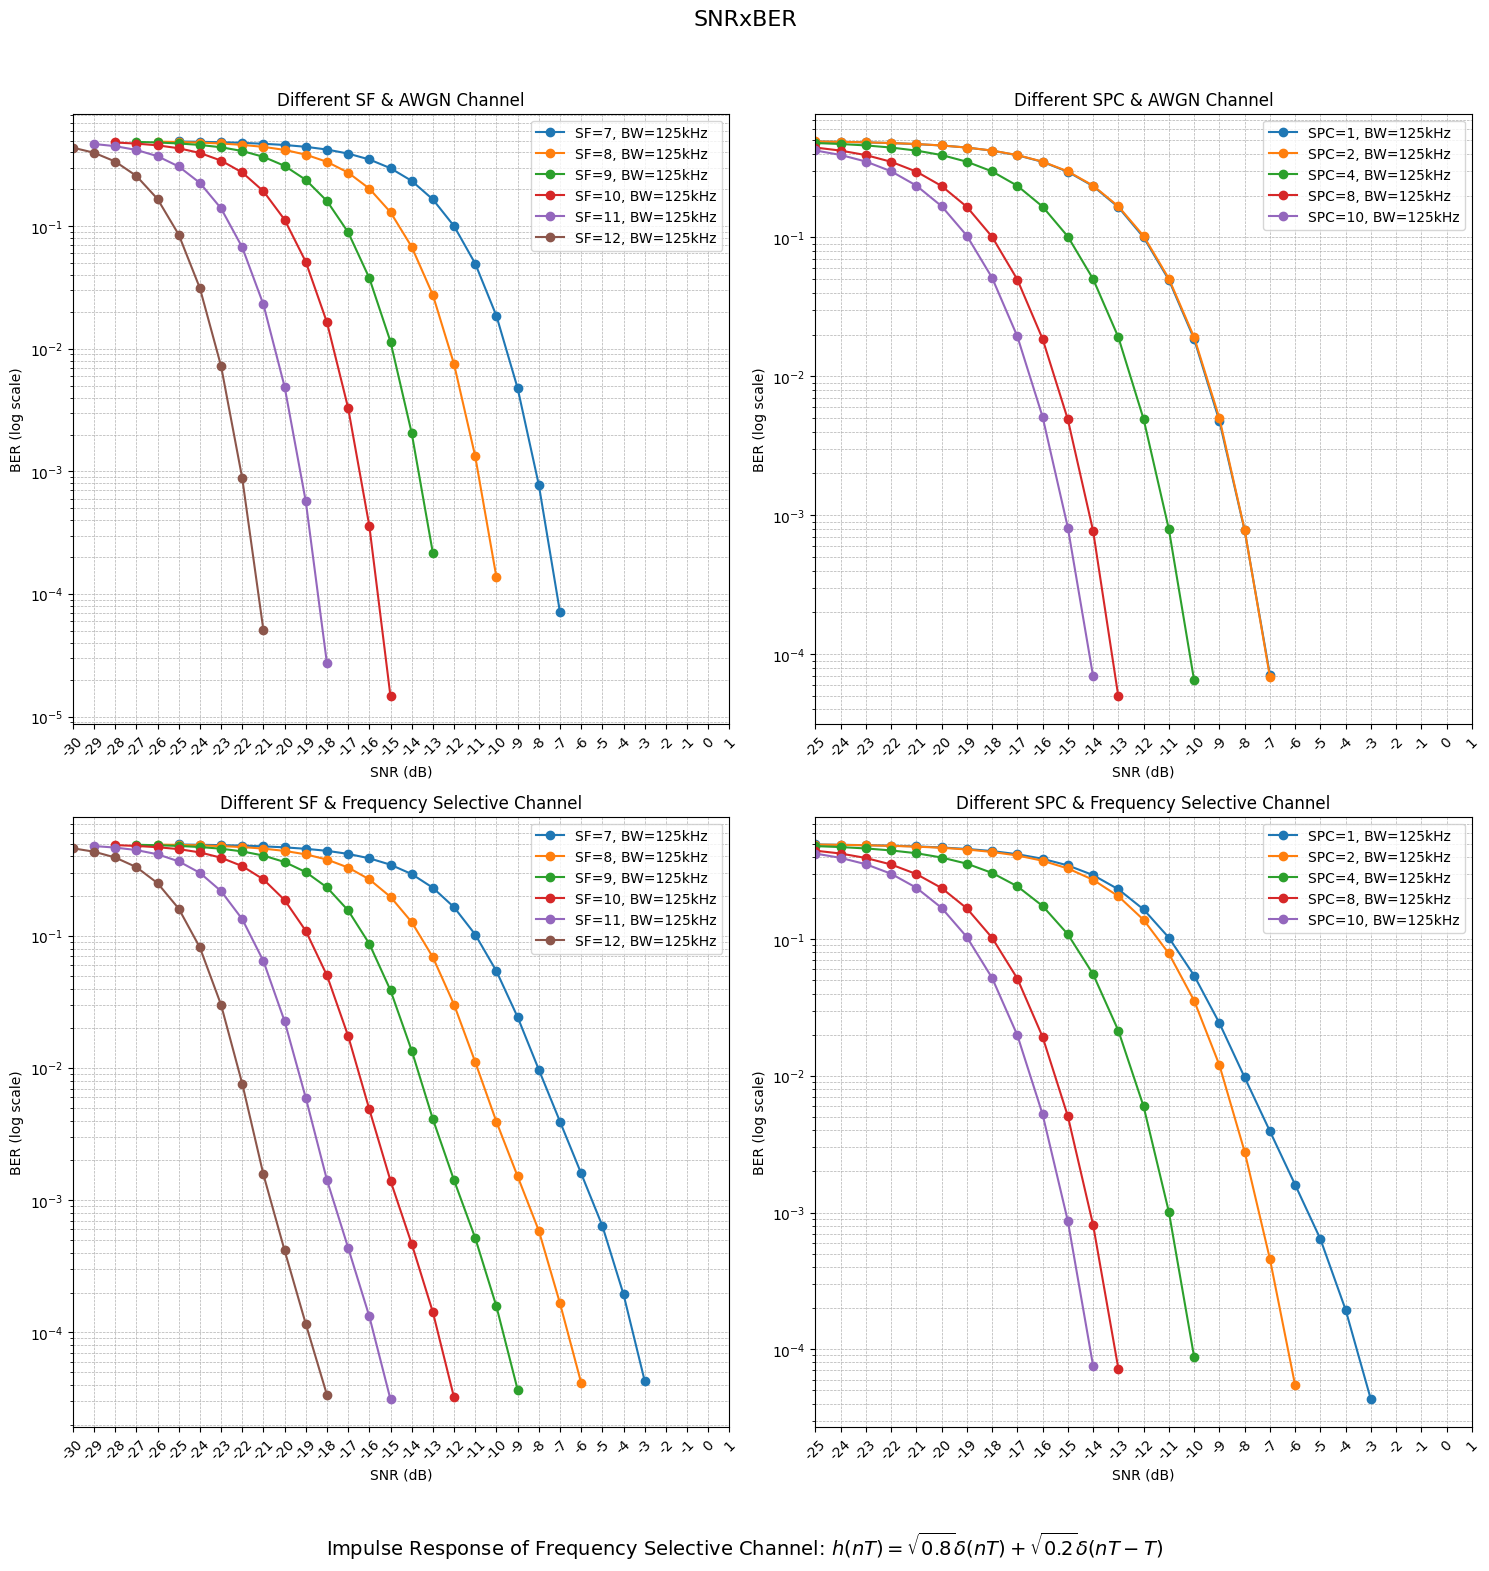

In [2]:
plot_all_snr_ber()

## 3. Explorando métricas de rendimiento: SNR x SER



Estos gráficos presentan la evolución de la **SER (Symbol Error Rate)** bajo distintas configuraciones de LoRa, en condiciones similares a las evaluadas para BER.

La interpretación de las curvas es análoga a la de BER, ya que ambas métricas reflejan el impacto del canal ruidoso sobre la precisión de recepción. Sin embargo, la SER suele ser **ligeramente más alta** que la BER, ya que un símbolo puede contener varios bits, y con que uno esté mal ya cuenta como símbolo erróneo.

Las conclusiones respecto a Spreading Factor (SF) y Samples per Chip (SPC) se mantienen:
- SF mejora consistentemente la SER.
- SPC también mejora la SER, pero con beneficios que tienden a saturarse a medida que crece.


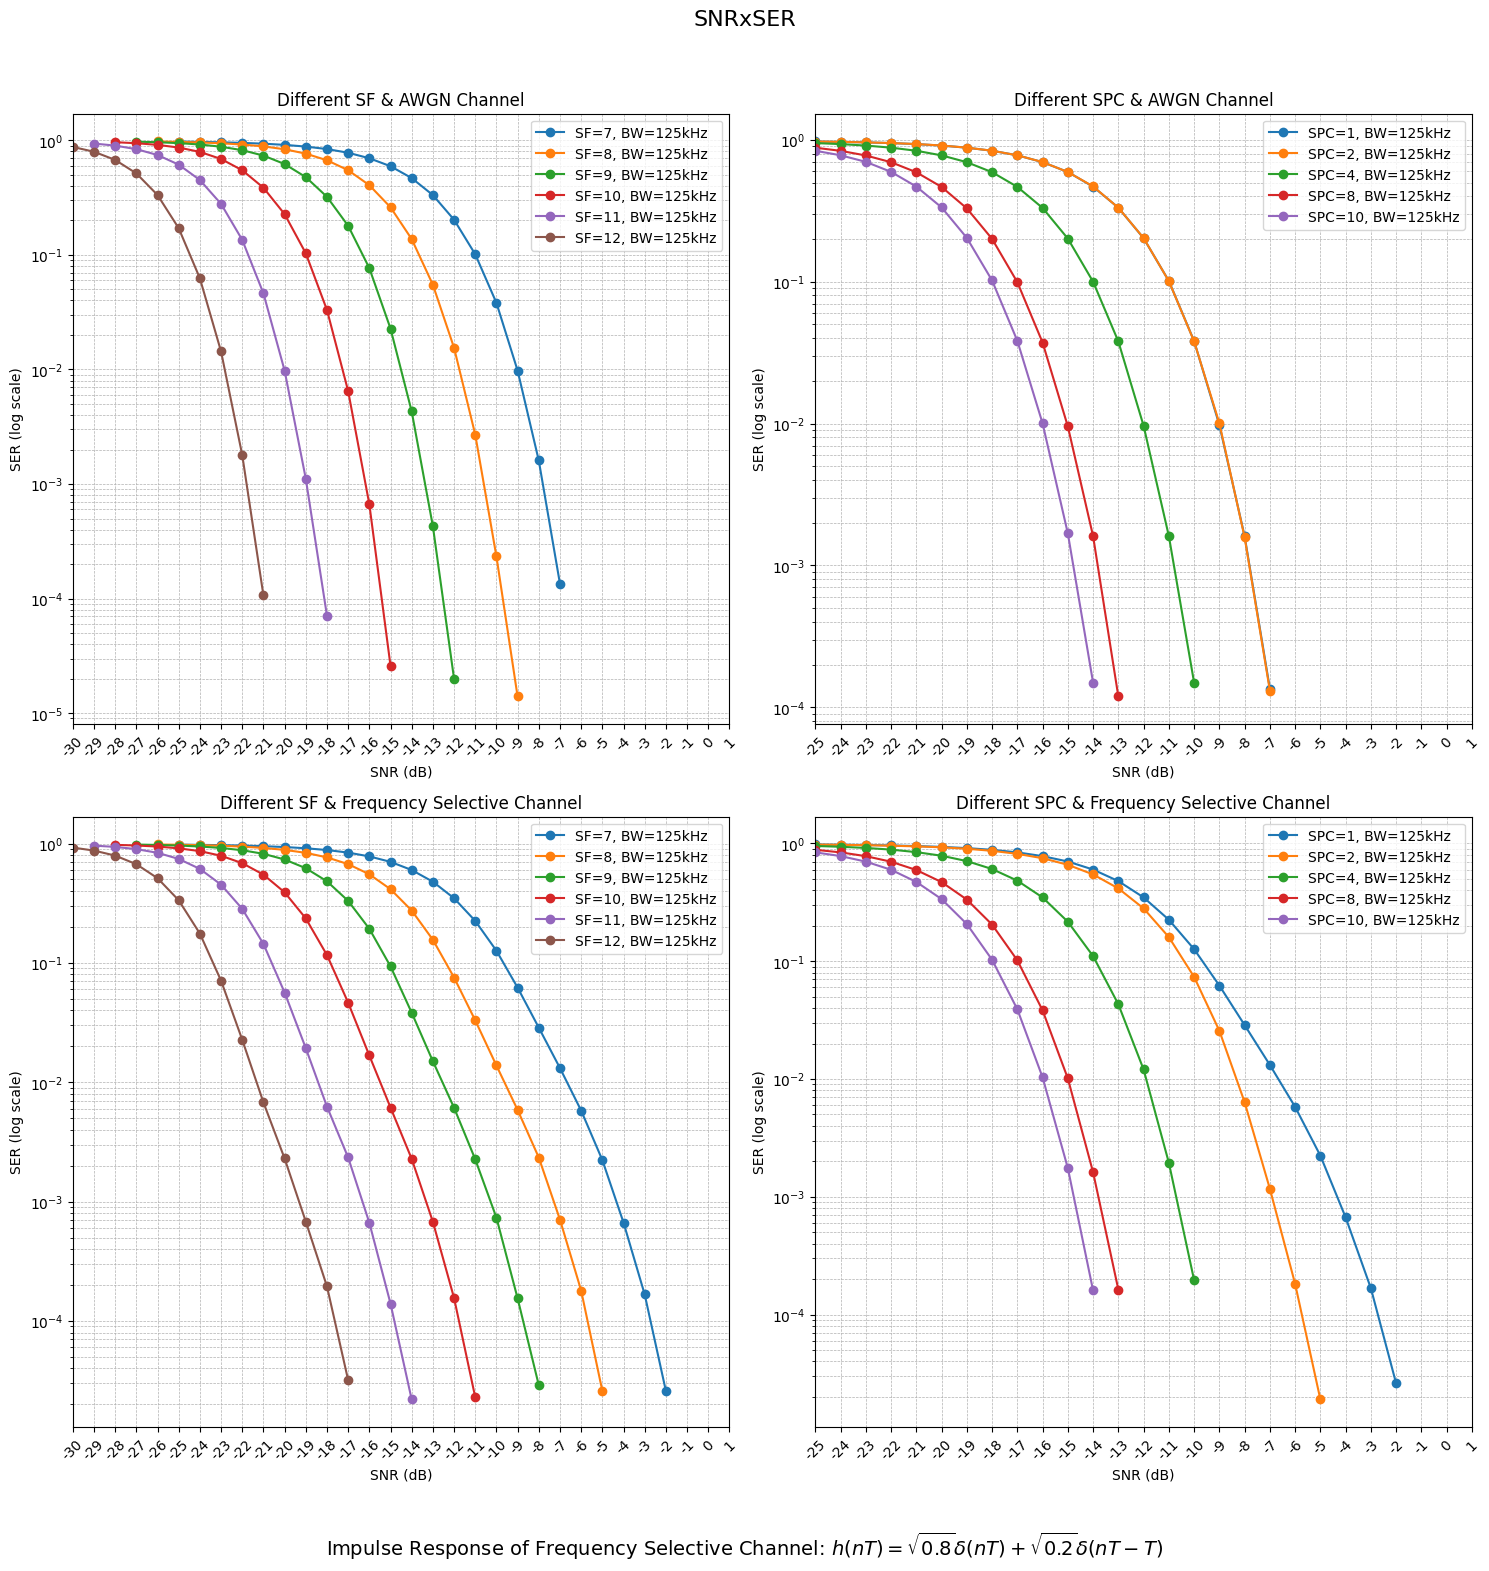

In [3]:
plot_all_snr_ser()

## 4. Comparación con la Implementación de Vangelista: SNR × BER




Este gráfico compara el desempeño en tasa de error de bit (**BER**) entre dos implementaciones de demodulación LoRa:

- **Implementación actual:** utiliza integración e información de fase.
- **Implementación basada en Vangelista:** versión simplificada sin retención de fase.

Ambas curvas muestran un comportamiento **idéntico** a partir de cierto umbral de SNR (aproximadamente −10 dB), indicando que las diferencias internas en la implementación **no impactan significativamente en la BER final** bajo estas condiciones.

Esto valida el enfoque alternativo implementado en nuestro trabajo como una opción funcionalmente equivalente en cuanto a precisión, al menos en escenarios de canal AWGN con SF = 7 y SPC = 1.

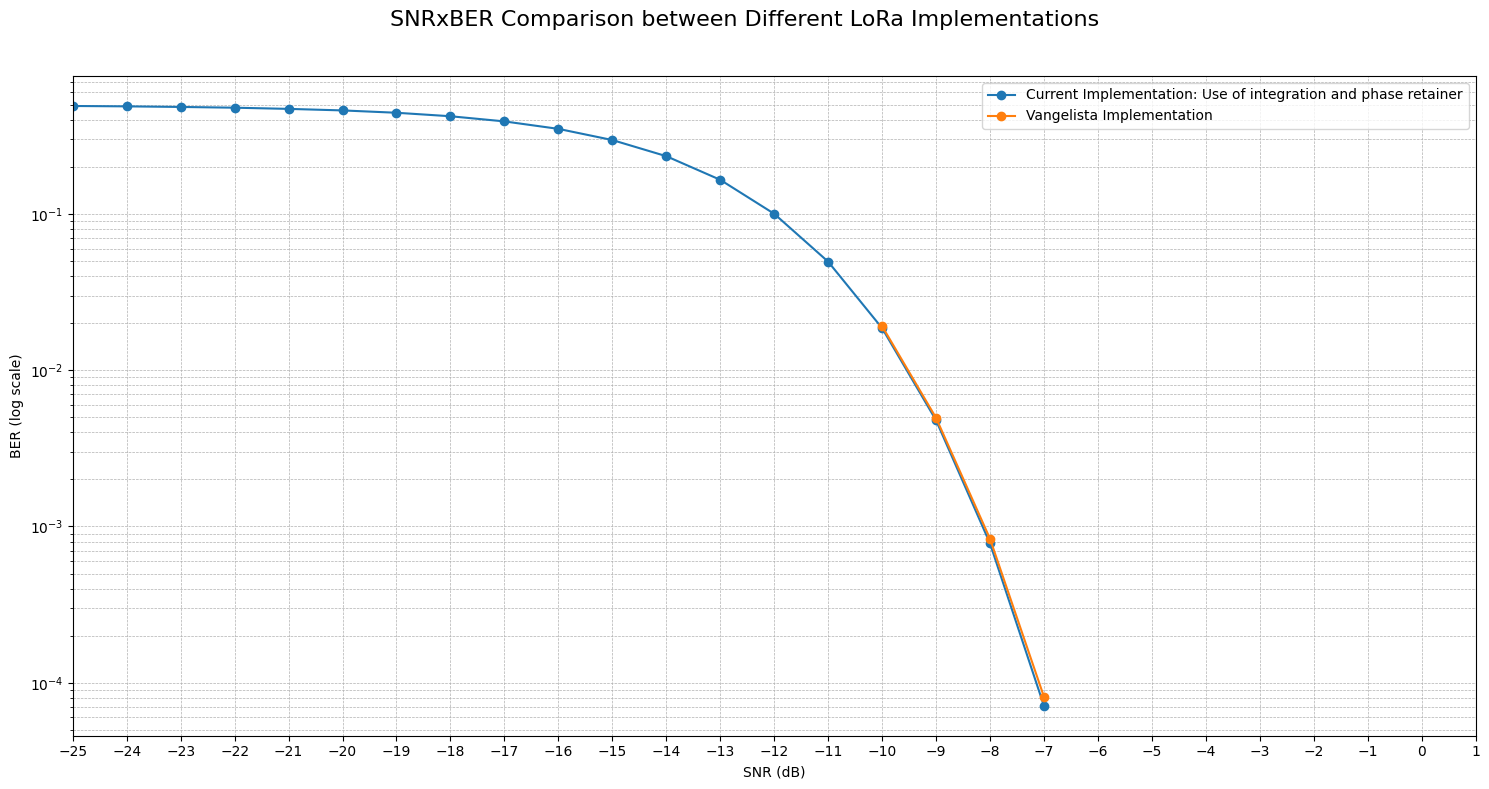

In [4]:
plot_vangelista_comparison()

## 5. Desempeño de un Sincronizador de trama basado en Correlación Cruzada



### 5.1. Explorando métricas de rendimiento: FER y SER (relativo) en contexto de recuperación de trama
En el siguiente gráfico se muestran los resultados de rendimiento para la recuperación de tramas mediante el uso de correlación cruzada.

Según la implementación de `correlation_based_synchronizer`, se obtienen dos métricas relevantes:

1. **SNR vs FER**$^1$: Representa la tasa de tramas que no pudieron recuperarse correctamente. Esto incluye casos donde la trama no fue encontrada, se lanzó una excepción, o el encabezado no pudo decodificarse.
2. **SNR vs SER relativa**: Evalúa la tasa de errores por símbolo **exclusivamente en las tramas que fueron correctamente sincronizadas y decodificadas**. Por lo tanto, mide la calidad del payload recuperado cuando la trama fue válida.

$^1$ Se utiliza FER en lugar de PER para reflejar con mayor precisión que se trata de **tramas completas** de protocolo LoRa y no simplemente paquetes abstractos.



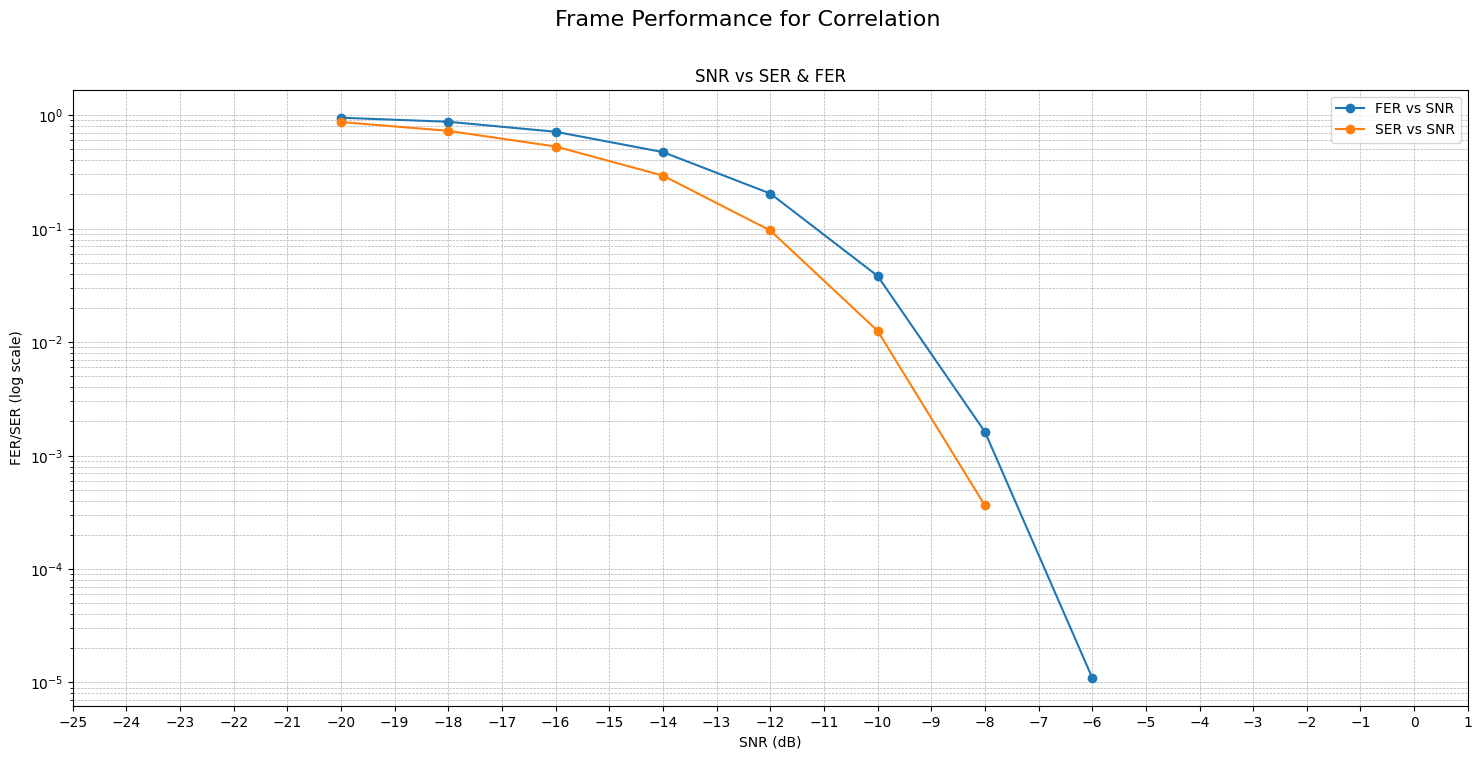

In [5]:
plot_frame_corr_performance()


### 5.2. Modo de sincronización Compacto vs Completo

Se desarrollaron dos modos de sincronización basados en correlación, que difieren en el **patrón de referencia** utilizado para detectar el comienzo de la trama:

- **Modo Compacto (`"COMPACT"`):**  
  Utiliza únicamente una sección acotada del SFD como plantilla de correlación, concretamente los **dos símbolos downchirp del SFD** más un **downchirp parcial (cuarto de ciclo)**. Esta estrategia busca minimizar la probabilidad de falsos positivos al acotar la correlación a una región que, por definición, solo debería aparecer antes del payload.

- **Modo Completo (`"FULL"`):**  
  Utiliza como plantilla de correlación el **preambulo completo más el SFD completo**, lo cual proporciona una señal de sincronización más robusta, pero a costa de un mayor riesgo de ambigüedad en algunos escenarios.

La distinción se implementó tras observar que, en ciertos casos específicos, el modo compacto ofrecía **mejor rendimiento que el modo completo**, lo cual puede parecer contraintuitivo.  
Esto se debe a que, cuando el payload contiene **muchos símbolos bajos (por ejemplo, ceros)**, la señal transmitida puede parecerse matemáticamente a una **upchirp**, generando falsos positivos en el modo completo. En cambio, el modo compacto evita estos símbolos ambiguos al limitarse a un segmento de referencia que no se replica naturalmente en el payload.

Esta observación se relaciona con el uso de **"marcadores" upchirp** dentro del protocolo LoRa, tal como se discute en el trabajo práctico.

#### Conclusión

El gráfico muestra que **ambos modos de sincronización (compacto y completo) logran resultados prácticamente idénticos en términos de tasa de error de trama (FER)** en todo el rango de SNR evaluado.

Aunque se planteó la hipótesis de que el **modo completo podría ser más vulnerable a falsos positivos**, especialmente ante payloads que contienen secuencias de símbolos bajos (como ceros), esta desventaja se **atenúa completamente cuando se considera el uso de capas superiores del stack de comunicación**, como lo es el scrambler de LoRa.

El **scrambler** introduce aleatoriedad controlada sobre el payload, dispersando patrones repetitivos o estructurados que pudieran asemejarse a chirps válidos del preámbulo o del SFD. De esta manera, **reduce drásticamente la probabilidad de que partes del payload generen correlaciones espurias** durante la etapa de detección.

En consecuencia, el riesgo teórico asociado al modo completo de correlación desaparece en la práctica cuando se considera un sistema LoRa implementado en su totalidad, con su pipeline de modulación y codificación completo. Por ello, **el modo completo sigue siendo válido y funcional**, incluso en presencia de posibles colisiones de patrones entre payload y marcadores de sincronización.



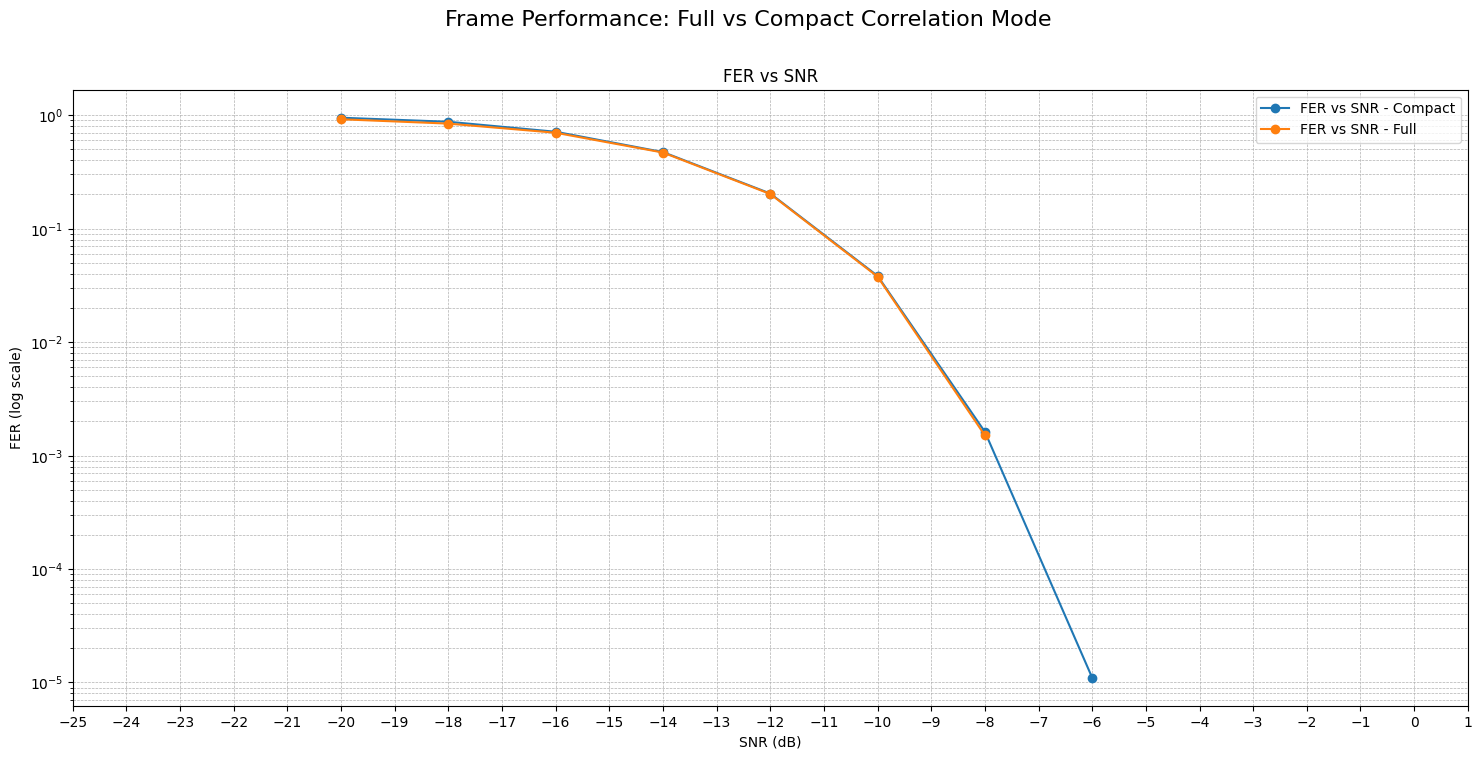

In [6]:
plot_frame_corr_mode_comparison()

## 6. Desempeño de un Sincronizador basado en Dechirping




Este gráfico presenta el rendimiento de un sincronizador que utiliza el método de **dechirping** para detectar y recuperar tramas en un sistema LoRa. Se muestran dos métricas clave en función del SNR:

- **FER (Frame Error Rate):** Tasa de tramas no recuperadas correctamente.
- **SER relativa (Symbol Error Rate):** Tasa de error de símbolo considerando solo los casos en los que la trama fue correctamente detectada y decodificada.

#### Observaciones

- Como era de esperarse, **FER es siempre mayor o igual a SER**, ya que incluye todos los casos de fallos: tanto errores de sincronización como errores de decodificación.
- A medida que el SNR mejora, ambas curvas decrecen rápidamente, mostrando una fuerte dependencia del ruido en el canal.
- A partir de valores de SNR cercanos a −12 dB, se nota un descenso pronunciado en ambas métricas, lo que indica una región de transición donde el sincronizador comienza a operar de forma confiable a partir de los -8 dB.


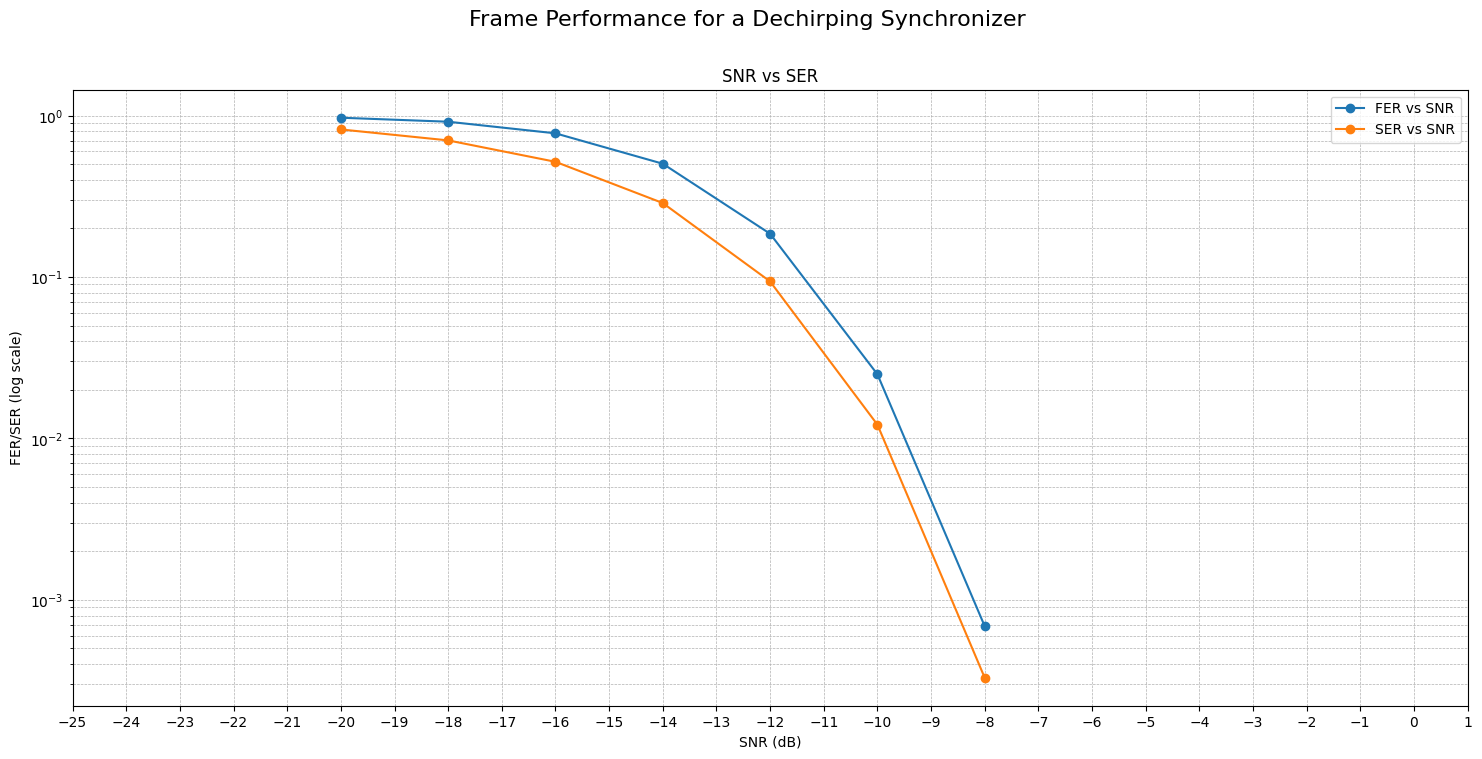

In [7]:
plot_frame_dechirp_performance()

## 7. Comparación entre Sincronizador por Dechirping y por Correlación




Este gráfico muestra una comparación directa del rendimiento en **tasa de error de trama (FER)** entre dos estrategias de sincronización para LoRa:

- **Dechirping Synchronizer:** Utiliza deschirpeo directo y análisis espectral para determinar los símbolos y sincronizar la trama.
- **Correlation-based Synchronizer:** Usa correlación cruzada con patrones de referencia (como el SFD o preámbulo) para detectar la posición de inicio de trama.

#### Observaciones

- Ambas curvas presentan un comportamiento muy similar en el rango de SNR analizado, lo que sugiere que **ambos métodos son comparables en términos de precisión de sincronización**.
- En valores de SNR bajos (−12 dB a −8 dB), **el sincronizador por dechirping muestra ventaja**, con menor FER. Esto puede deberse a su capacidad de adaptarse más directamente a los patrones espectrales del chirp, evitando falsas correlaciones.
- El tiempo que tardó **el sincronizador por correlación** fue mucho menor, debido al overhead computacional que implica inyectar lógica comparativa y secuencial en la detección de trama por dechirping, ya que esta sí o sí culmina en la decodificación de símbolos a nivel intermedio.

#### Consideraciones prácticas

- El sincronizador por dechirping suele ser **más preciso*, ya que evita operaciones de correlación intensiva.
- El sincronizador por correlación, en cambio, puede ofrecer **menor complejidad computacional** sobre los patrones de sincronización utilizados (p. ej. modo compacto vs completo).



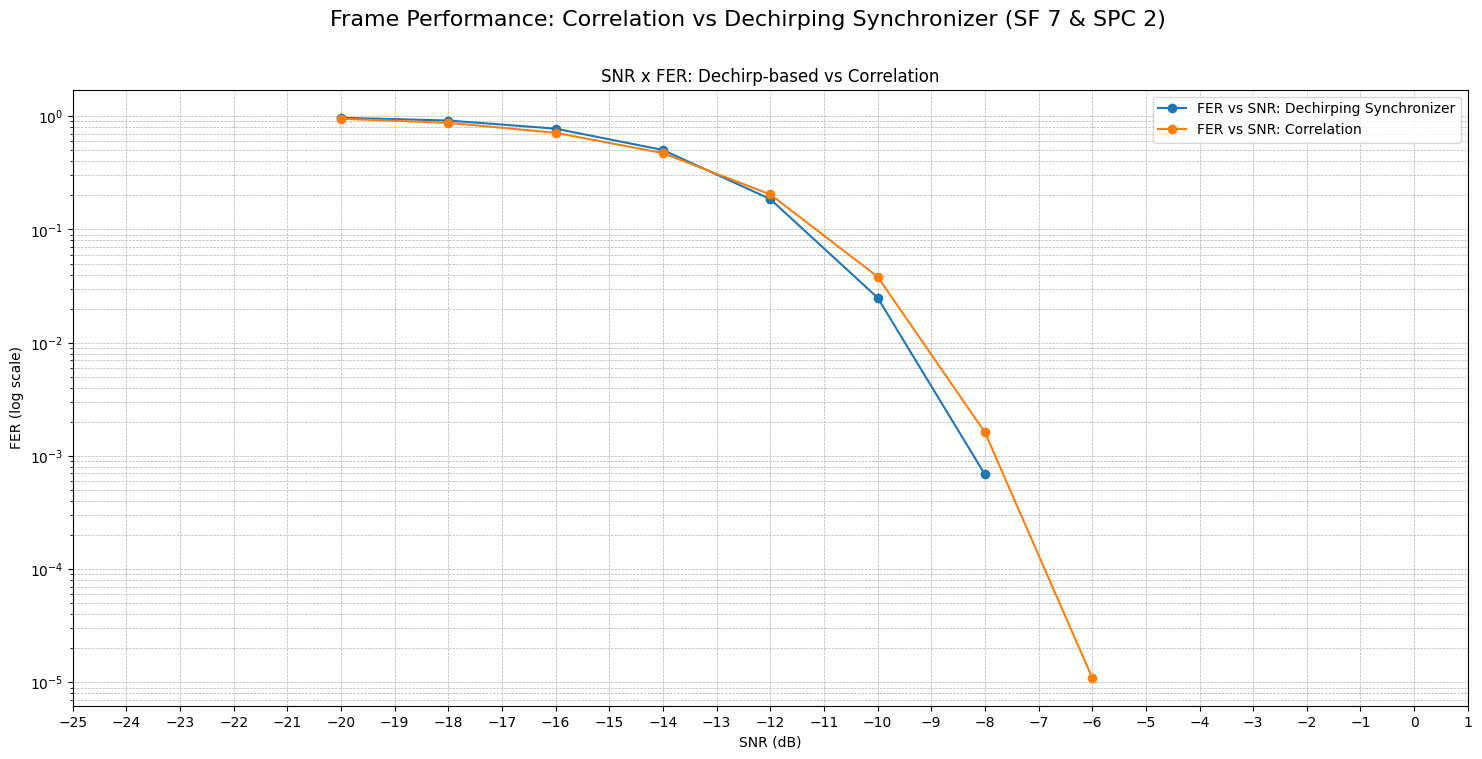

In [8]:
plot_frame_dechirp_vs_corr_performance()